<div class="alert alert-success">
    <h1 align="center">Image reconstruction using Convolutional Variational Auto Encoder</h1>
    <h3 align="center"><a href="https://ca.linkedin.com/in/mohammad-baradaran-09084241">MOHAMMAD BARADARAN</a>
</h3>
</div>

 <h3 align='center'> Architecture of the Deep Neural Network </h3>

<img src='vae.png' width='90%'/>

## Importing the Libraries

In [34]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
from random import randint


import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as tfms
from torchvision.utils import save_image
from torchsummary import summary

from IPython.display import Image
from IPython.core.display import Image, display



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
use_GPU=torch.cuda.is_available()  # if True: GPU is ready and you can add '.cuda' for model and input, else remove .cuda from code
use_GPU

True

In [70]:
# Hyper parameters
batch_size = 32
lr=1e-3  # learning rate
sz=227   # size of the input images
z_dim=64 # dimension of latent layer
epochs = 20  # number of the iterations

In [42]:
# Dataset /Transforms /Dataloader ---- for training


#data_dir='/dataset/yourdataset'     # toy can just your dataset( containing train +test + valid folders) in the folder named dataset in directory

data_dir='/gel/usr/mobar48/Desktop/datasets/orl_faces' # path of the dataset direction
trn_dir=f'{data_dir}/train' # reffering to Train folder inside the dataset

trn_tfms=tfms.Compose([                # preparing the transform for training dataset
    tfms.Resize((sz,sz)),              # making all the input size equal (as they may have different sizes)
    tfms.ToTensor()
])
trn_ds=datasets.ImageFolder(trn_dir,transform=trn_tfms)  # it shows the images path and labels to dataloader
dataloader=DataLoader(trn_ds,batch_size=batch_size,shuffle=False, num_workers=8) # load data from dataset in batches

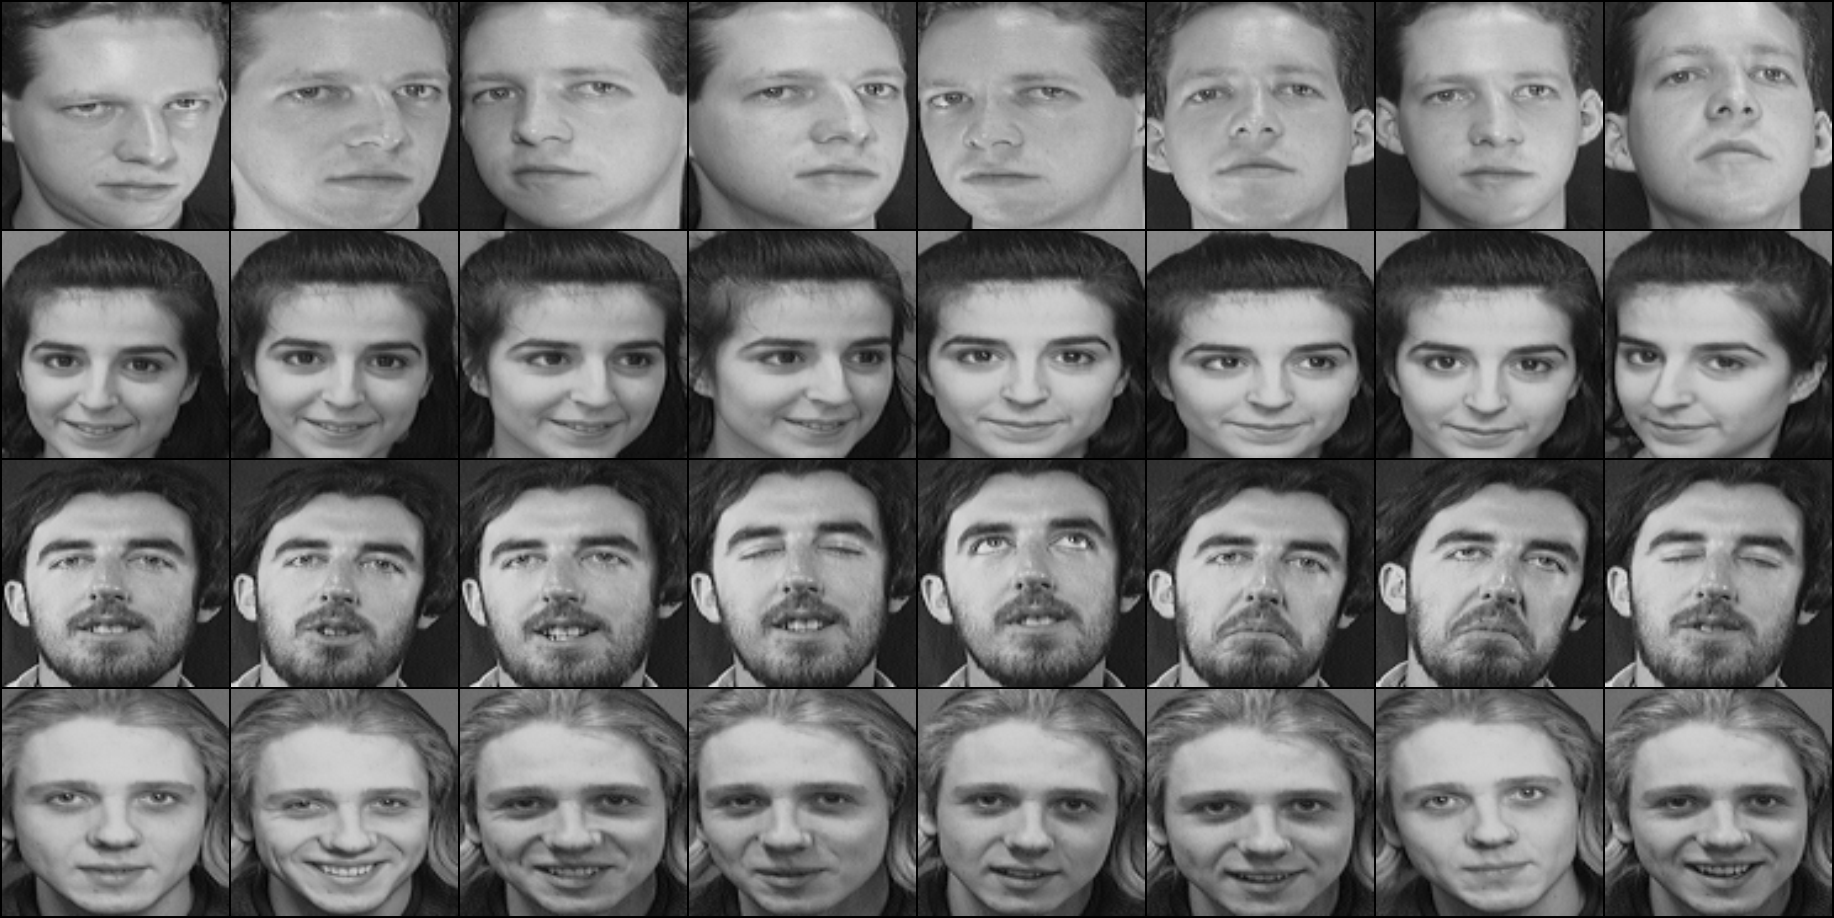

In [43]:
# visualizing one batch of input images (row* column =batch_size)
vis_input, _ = next(iter(dataloader))
save_image(vis_input, 'outputs/samples-of-input-data.png')

Image('outputs/samples-of-input-data.png')

In [44]:
vis_input.shape  # shape of input in each iteration (batch_size, channels,sz,sz)

torch.Size([32, 3, 227, 227])

In [45]:
class Flatten(nn.Module):   # falatten the image to vector (incloding the batch)
    def forward(self, input):
        return input.view(input.size(0), -1)   # (batch_size, channels,sz,sz) ---> (batch_size,channels*sz*sz)

In [46]:
class UnFlatten(nn.Module):  # reverse of flatten function
    def forward(self, input, size=128):
        return input.view(input.size(0), size, 14, 14)  # (batch_size, channels*sz*sz) ---> (batch_size,channels,sz,sz)

In [47]:
channels=vis_input.shape[1]  # number of the image channels

## Creating the model (convolutional va-AE)

In [48]:

class conv_VAE(nn.Module):
    def __init__(self, image_channels=channels, h_dim=25088, z_dim=z_dim):  #h_dim : dimension of hidden layer & z_dim: dimension of  latent layer ( and also is equal to size of  mean and standard devation) 
        super(conv_VAE, self).__init__()
        
        self.cv1=nn.Sequential(
            nn.Conv2d(3,512,kernel_size=11,stride=4,padding=2),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU()
        )
        
        
        self.pl1=nn.MaxPool2d(2,stride=2,return_indices=True)  # returning indices is needed for unpooling
               
        self.cv2=nn.Sequential(
            nn.Conv2d(512,256,kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU()
        )
        self.pl2=nn.MaxPool2d(2,stride=2,return_indices=True)   
               
        self.cv3=nn.Sequential(
            nn.Conv2d(256,128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU()
        )
        self.fl=Flatten()
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.cvt1=nn.Sequential(
            
            nn.ConvTranspose2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU()
    
        )
        self.unpl1=nn.MaxUnpool2d(2,stride=2)

        self.cvt2=nn.Sequential(
            nn.ConvTranspose2d(256,512,kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU()    
        )
        self.unpl2=nn.MaxUnpool2d(2,stride=2)
        
        
        self.cvt3=nn.Sequential(
            nn.ConvTranspose2d(512,3,kernel_size=11,stride=4,padding=2),
            nn.Sigmoid()    
        )
        self.unfl=UnFlatten()
           
        
    def reparameterize(self, mu, logvar):  # producing latent layer (Guassian distribution )
        std = logvar.mul(0.5).exp_()       # hint: var=std^2
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).cuda()   # normal unit distribution in shape of mu
        z = mu + std * esp     # mu:mean  std: standard deviation
        return z
    
    def bottleneck(self, h):      # hidden layer ---> mean layer + logvar layer
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar


    def forward(self, x):   
        
        out=self.cv1(x)      #512*56*56    if input is (3,227,227)
        size1=out.size()     #512*56*56
        out,i1=self.pl1(out) #512*28*28
        out=self.cv2(out)    #256*28*28
        size2=out.size()     #256*28*28
        out,i2=self.pl2(out) #256*14*14
        
        out=self.cv3(out)    #128*14*14
        h=self.fl(out)       #25088
        
        
        z, mu, logvar = self.bottleneck(h)    #each: 64
        h = self.fc3(z)      #25088
        
       
        # decoder
        out=self.unfl(h)     #128*14*14
        out=self.cvt1(out)   #256*14*14
        
        out=self.unpl1(out,i2,output_size=size2)#256*28*28
        # print(out.size())
        out=self.cvt2(out)   #512*28*28
        out=self.unpl2(out,i1,output_size=size1)#512*56*56
        out=self.cvt3(out)   #3*227*227
        
        
        return out, mu, logvar
        

In [49]:

model = conv_VAE(image_channels=channels)
model.cuda()

conv_VAE(
  (cv1): Sequential(
    (0): Conv2d(3, 512, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pl1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv2): Sequential(
    (0): Conv2d(512, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pl2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv3): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fl): Flatten()
  (fc1): Linear(in_features=25088, out_features=64, bias=True)
  (fc2): Linear(in_features=25088, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=25088, bi

In [50]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 

In [51]:
def loss_fn(recon_x, x, mu, logvar):   # defining loss function for va-AE (loss= reconstruction loss + KLD (to analyse if we have normal distributon))
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    
    
    # source: Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # KLD is equal to 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [52]:
!rm -rfr outputs
!mkdir outputs

## training the model

In [71]:
# training
for epoch in range(epochs):
    for idx, (images, _) in enumerate(dataloader):
        images=Variable(images).cuda()
        #print(type(images))
        recon_images, mu, logvar = model(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)  # loss calcualtion
        optimizer.zero_grad()  
        loss.backward()   # back propagation
        optimizer.step()# optimizing the parameters

        to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                epochs, loss.detach().item()/batch_size, bce.detach().item()/batch_size, kld.data.detach().item()/batch_size)
        if (idx%50==0):
            print(to_print)

torch.save(model.state_dict(), 'vae_parameters.torch')  # to save learned parameters (weights and biases)

Epoch[1/20] Loss: 89741.508 89735.586 5.921
Epoch[2/20] Loss: 89789.609 89784.141 5.471
Epoch[3/20] Loss: 89766.453 89760.383 6.067
Epoch[4/20] Loss: 89774.102 89768.477 5.625
Epoch[5/20] Loss: 89753.961 89748.625 5.336
Epoch[6/20] Loss: 89729.688 89723.977 5.713
Epoch[7/20] Loss: 89726.750 89720.719 6.033
Epoch[8/20] Loss: 89729.828 89724.320 5.505
Epoch[9/20] Loss: 89707.734 89702.188 5.546
Epoch[10/20] Loss: 89713.727 89708.133 5.597
Epoch[11/20] Loss: 89691.672 89686.203 5.468
Epoch[12/20] Loss: 89724.203 89718.609 5.593
Epoch[13/20] Loss: 89702.281 89696.805 5.474
Epoch[14/20] Loss: 89720.617 89715.359 5.262
Epoch[15/20] Loss: 89739.078 89733.672 5.404
Epoch[16/20] Loss: 89724.117 89718.422 5.698
Epoch[17/20] Loss: 89839.398 89833.914 5.483
Epoch[18/20] Loss: 89741.867 89736.430 5.434
Epoch[19/20] Loss: 89917.539 89911.875 5.660
Epoch[20/20] Loss: 89753.773 89748.062 5.711


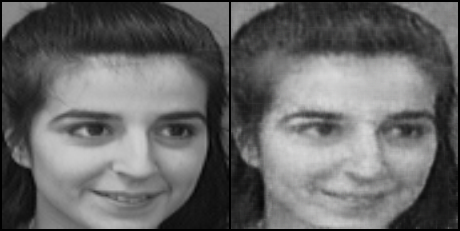

In [68]:
# showing the original and reconstructed image in one figure
sample = trn_ds[randint(1, 50)][0].unsqueeze(0)
sample=sample.cuda()
recon_x, _, _ = model(sample)
fuse=torch.cat([sample, recon_x])   # concatination of original image and reconstructed one


save_image(fuse.data.cpu(), 'outputs/original-reconstructed.png')
display(Image('outputs/original-reconstructed.png', width=600,unconfined=True))